In [1]:
# general package imports
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import auc, roc_curve, log_loss

import warnings; warnings.simplefilter('ignore')

In [2]:
# cnn imports
import cv2
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Activation,MaxPooling2D,Dense,Flatten,Dropout

2023-05-29 12:07:37.919473: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Plot some images

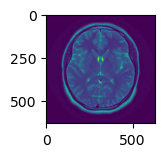

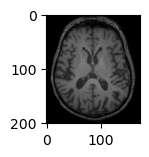

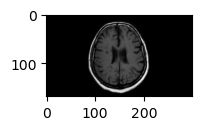

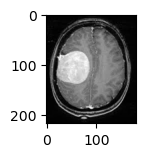

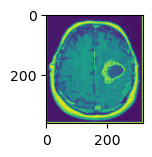

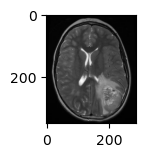

In [3]:
from matplotlib import pyplot
from matplotlib.image import imread

# define location of dataset
folder_no = 'data/brain_tumor_dataset/no'
folder_yes = 'data/brain_tumor_dataset/yes'

i = 0

for filepath, gt in zip([folder_no,folder_yes],[0,1]):

    # plot first few images
    for f in os.listdir(filepath)[0:3]:
        
        i = i+1

        # define subplot
        pyplot.subplot(330 + 1 + i)

        # define filename
        filename = filepath + '/' + f

        # load image pixels
        image = imread(filename)

        # plot raw pixel data
        pyplot.imshow(image)

        # show the figure
        pyplot.show()

# Images are not consistent in shape or channels (some grayscale, some not), so standardize the images first...

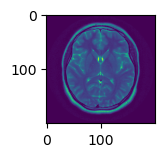

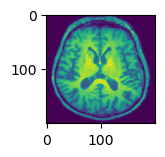

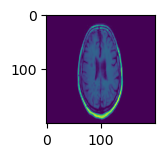

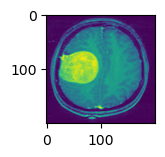

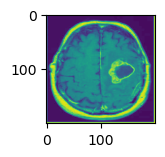

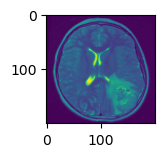

In [4]:
from matplotlib import pyplot
from matplotlib.image import imread

# define location of dataset
folder_no = 'data/brain_tumor_dataset/no'
folder_yes = 'data/brain_tumor_dataset/yes'

i = 0

for filepath, gt in zip([folder_no,folder_yes],[0,1]):

    # plot first few images
    for f in os.listdir(filepath)[0:3]:
        
        i = i+1

        # define subplot
        pyplot.subplot(330 + 1 + i)

        # define filename
        filename = filepath + '/' + f

        # load image pixels
        image = imread(filename)

        # resize into standard size for all images
        resized_image = cv2.resize(image,dsize=(200,200))
        
        # in case of grayscale images
        if len(np.shape(resized_image)) > 2:
            
            # convert the image from COLOR_BGR2GRAY
            resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
                
        # plot raw pixel data
        pyplot.imshow(resized_image)

        # show the figure
        pyplot.show()

# Read images into array

In [5]:
filepath = 'data/brain_tumor_dataset/'

images, labels, filenames = [], [], []

for gt in ['yes','no']:
    
    filepath_gt = filepath + gt
    
    for f in os.listdir(filepath_gt):

        filename = filepath_gt + '/' + f
        
        if '._' not in filename: # metadata files created by macos

            # load image
            photo = tf.keras.utils.load_img(path=filename,target_size=(200, 200))

            # load image pixels
            image = imread(filename)
            resized_image = cv2.resize(image,dsize=(200,200))

            # in case of grayscale images
            if len(np.shape(resized_image)) > 2:
                # convert the image from COLOR_BGR2GRAY
                resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
            
            # store to array
            images.append(resized_image)
            filenames.append(filename)

            if gt=='yes':
                label = 1
                labels.append(label)
            elif gt=='no':
                label = 0
                labels.append(label)            

# Split into train/test sets (stratify by GT)

In [6]:
from sklearn.model_selection import train_test_split

gtFr = pd.DataFrame(labels).rename(columns={0:'gt'}).reset_index(drop=False).rename(columns={'index':'pID'})
gtFr['filename'] = filenames

# split into training and testing sets, stratifying by gt for equal representation
trainFr, testFr = train_test_split(gtFr, test_size=0.2, stratify=gtFr['gt'])

# store training/testing indices
trainFr['set'] = 'train'
testFr['set'] = 'test'

gtFr2 = pd.concat([trainFr,testFr],axis=0)
gtFr2.set_index(['filename']).to_csv('gtFr.csv')

# Load and reformat training data

In [7]:
files_train = []
X_train = []
y_train = []

for idx, row in trainFr.iterrows():
    # load image pixels
    image = imread(row['filename'])
    
    # resize image to standard 200x200
    resized_image = cv2.resize(image,dsize=(200,200))
    
    # in case of grayscale images
    if len(np.shape(resized_image)) > 2:
        # convert the image from COLOR_BGR2GRAY
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # store to array
    X_train.append(resized_image)
    y_train.append(row['gt'])
    files_train.append(row['filename'])
    
# reshape data to fit model
X_train = np.array(X_train).reshape(len(trainFr),200,200,1)
y_train = np.array(y_train)

# Load and reformat testing data

In [8]:
files_test = []
X_test = []
y_test = []

for idx, row in testFr.iterrows():
    # load image pixels
    image = imread(row['filename'])
    
    # resize image to standard 200x200
    resized_image = cv2.resize(image,dsize=(200,200))
    
    # in case of grayscale images
    if len(np.shape(resized_image)) > 2:
        # convert the image from COLOR_BGR2GRAY
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # store to array
    X_test.append(resized_image)
    y_test.append(row['gt'])
    files_test.append(row['filename'])
    
# reshape data to fit model
X_test = np.array(X_test).reshape(len(testFr),200,200,1)
y_test = np.array(y_test)

# Build, compile, and train CNN 

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

# create model
model = Sequential()

# add convolutional layer
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(200,200,1))) # specify shape of images

# add max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add another convolutional layer
model.add(Conv2D(32, kernel_size=3, activation='relu'))

# add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten output (connect convolutional layers and dense layers)
model.add(Flatten())

# add a dense layer with 128 neurons and ReLU activation
model.add(Dense(128, activation='relu'))

# add dense layer
model.add(Dense(1, activation='sigmoid')) 

# compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Plot the training and validation accuracy against number of epochs

Epoch 1/30
7/7 [==============================] - 7s 891ms/step - loss: 101.8812 - accuracy: 0.5941 - val_loss: 14.1976 - val_accuracy: 0.7451
Epoch 2/30
7/7 [==============================] - 6s 898ms/step - loss: 4.7081 - accuracy: 0.8020 - val_loss: 1.4390 - val_accuracy: 0.7255
Epoch 3/30
7/7 [==============================] - 7s 973ms/step - loss: 0.4833 - accuracy: 0.8317 - val_loss: 0.7082 - val_accuracy: 0.6667
Epoch 4/30
7/7 [==============================] - 6s 919ms/step - loss: 0.3902 - accuracy: 0.8069 - val_loss: 0.6923 - val_accuracy: 0.7451
Epoch 5/30
7/7 [==============================] - 7s 1s/step - loss: 0.2787 - accuracy: 0.8663 - val_loss: 0.7548 - val_accuracy: 0.7647
Epoch 6/30
7/7 [==============================] - 7s 1s/step - loss: 0.1755 - accuracy: 0.9208 - val_loss: 1.1097 - val_accuracy: 0.7451
Epoch 7/30
7/7 [==============================] - 8s 1s/step - loss: 0.1077 - accuracy: 0.9554 - val_loss: 1.2017 - val_accuracy: 0.7451
Epoch 8/30
7/7 [==========

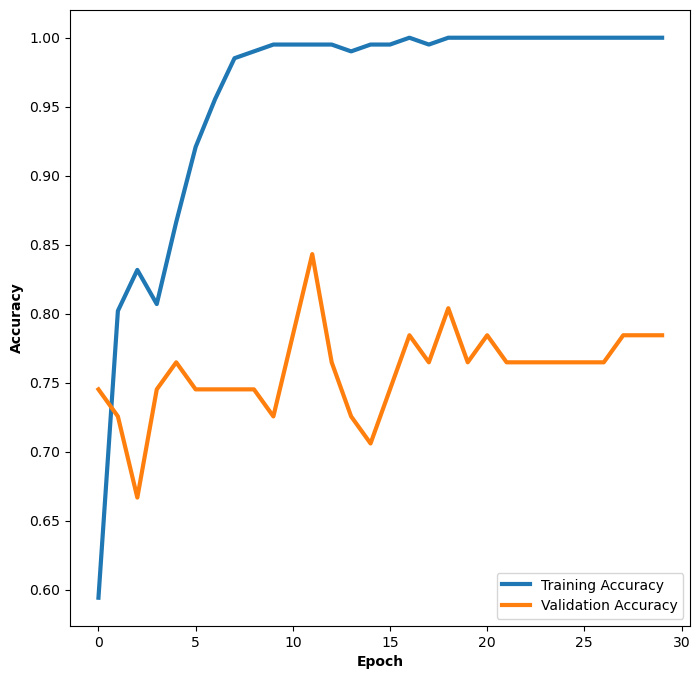

In [10]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30)

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.plot(history.history['accuracy'], label='Training Accuracy',lw=3)
ax.plot(history.history['val_accuracy'], label='Validation Accuracy',lw=3)
ax.set_xlabel('Epoch',weight='bold')
ax.set_ylabel('Accuracy',weight='bold')
ax.legend()

# Make predictions

In [12]:
# make predictions
predictions = model.predict(X_test)

# store as probabilities
probabilities = [p[0] for p in predictions]
testFr['pred'] = probabilities

# store as binary class predictions
binary_classes = [int(round(p[0])) for p in predictions]
testFr['classPred'] = binary_classes

2/2 [==============================] - 2s 327ms/step


# Evaluate results

In [13]:
from sklearn.metrics import classification_report

print(classification_report(testFr['gt'], testFr['classPred']))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79        20
           1       0.85      0.90      0.88        31

    accuracy                           0.84        51
   macro avg       0.84      0.83      0.83        51
weighted avg       0.84      0.84      0.84        51



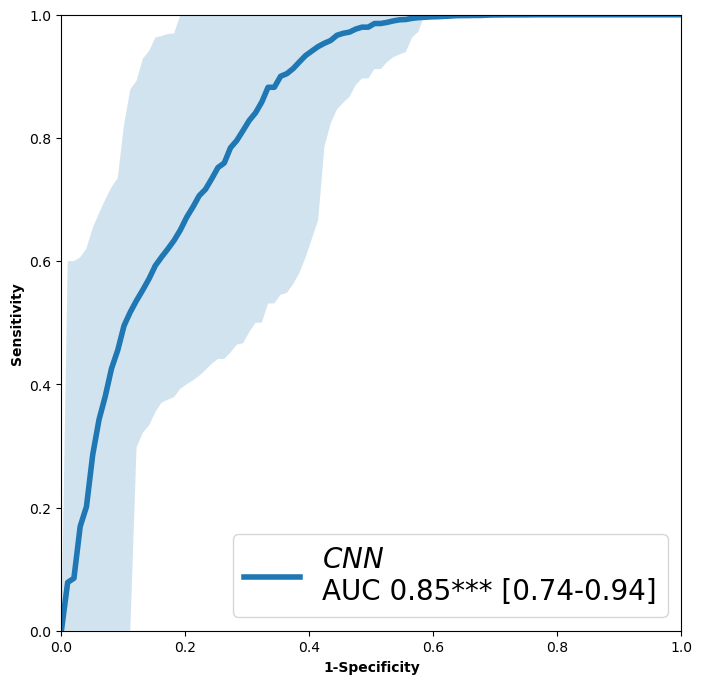

<Figure size 640x480 with 0 Axes>

In [14]:
sys.path.append('lib/include')
from utils import *

plotROCcomparison(testFr.dropna(), ['pred'], names=['$CNN$']) 

plt.savefig('figures/roc.png')

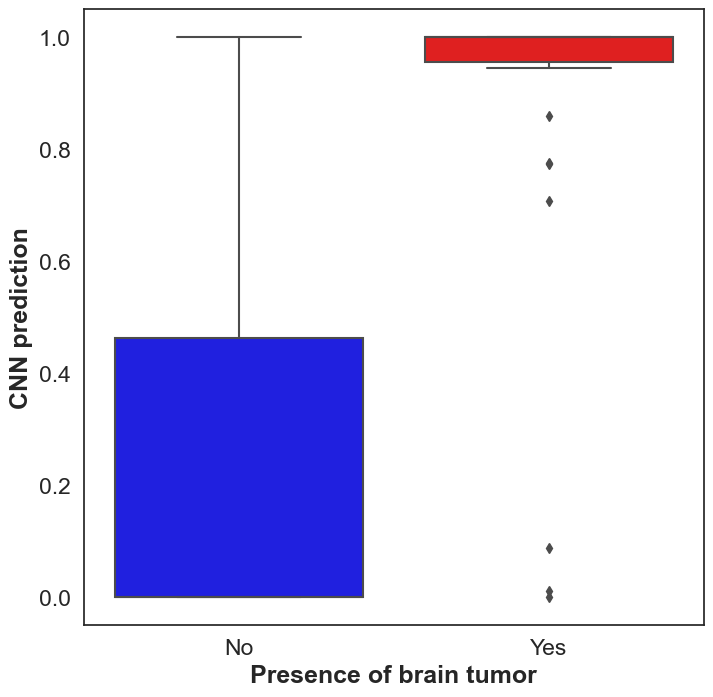

In [15]:
import seaborn as sns

sns.set(font_scale=1.5)
sns.set_style('white')

fig, ax = plt.subplots(1,1,figsize=(8,8))
sns.boxplot(y=testFr['pred'],x=testFr['gt'],palette=['blue','red'])
ax.set_xticklabels(['No','Yes'])
ax.set_xlabel('Presence of brain tumor',weight='bold')
ax.set_ylabel('CNN prediction',weight='bold')

plt.savefig('figures/cnn_prediction_boxplot_by_gt.png')